# Predicting Customer Satisfaction


##1. Installing and Importing Libraries

In [ ]:
!pip install lightgbm
!pip install datetime
!pip install plotly
!pip install more_itertools
!pip install imblearn
!pip install fast_ml
!pip install xgboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 7.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.utilities import display_all
from fast_ml import eda
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import datetime as dt
from scipy import stats
from more_itertools import unique_everseen
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna
import pickle

##2. Data Loading & Analysis

In [ ]:
orders_df = pd.read_csv('olist_orders_dataset.csv', engine='python')
order_items = pd.read_csv('olist_order_items_dataset.csv', engine='python')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', engine='python')
products = pd.read_csv('olist_products_dataset.csv', engine='python')
product_category = pd.read_csv('product_category_name_translation.csv', engine='python')
customer = pd.read_csv('olist_customers_dataset.csv', engine='python')
payments = pd.read_csv('olist_order_payments_dataset.csv', engine='python')
sellers = pd.read_csv('olist_sellers_dataset.csv', engine='python')

In [ ]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [ ]:
order_items.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


In [ ]:
order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [ ]:
products.head(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


In [ ]:
products.dtypes

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [ ]:
product_category.head(10)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


In [ ]:
product_category.dtypes

product_category_name            object
product_category_name_english    object
dtype: object

In [ ]:
customer.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


In [ ]:
payments.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95


In [ ]:
categories = products.merge(product_category, on = 'product_category_name', how = 'left')

In [ ]:
categories

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [ ]:
sellers.head(10)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE
7,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP
8,768a86e36ad6aae3d03ee3c6433d61df,1529,sao paulo,SP
9,ccc4bbb5f32a6ab2b7066a4130f114e3,80310,curitiba,PR


In [ ]:
orders = pd.merge(order_reviews, order_items, how = 'left', on = 'order_id')
orders = pd.merge(orders, orders_df, how = 'left', on = 'order_id')
orders = pd.merge(orders, customer, how = 'left', on = 'customer_id')
orders = pd.merge(orders, categories, how = 'left', on = 'product_id')
orders = pd.merge(orders, sellers, how = 'left', on = 'seller_id')
orders = pd.merge(orders, payments, how = 'left', on = 'order_id')

In [ ]:
orders.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,...,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,...,14.0,14.0,computers_accessories,12233.0,sao jose dos campos,SP,1.0,credit_card,1.0,88.09
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,computers_accessories,37175.0,ilicinea,MG,1.0,credit_card,1.0,194.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,garden_tools,37175.0,ilicinea,MG,1.0,credit_card,1.0,222.84
5,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1.0,3880d25d502b15b1de6fddc42ad1d67a,989becdce12ebc39863c2bceab6f3ca1,...,35.0,50.0,sports_leisure,81730.0,curitiba,PR,1.0,credit_card,10.0,1333.25
6,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,1.0,c45d02cc82cd779835094de9b29272cb,da8622b14eb17ae2831f4ac5b9dab84a,...,6.0,36.0,bed_bath_table,13405.0,piracicaba,SP,1.0,credit_card,1.0,462.70
7,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,2.0,c45d02cc82cd779835094de9b29272cb,da8622b14eb17ae2831f4ac5b9dab84a,...,6.0,36.0,bed_bath_table,13405.0,piracicaba,SP,1.0,credit_card,1.0,462.70
8,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,3.0,4e3550b4ebca5e32ccc3d32b3470e31f,41ab63a91b8b264e8c8780368bf1dd5b,...,22.0,17.0,bed_bath_table,31555.0,belo horizonte,MG,1.0,credit_card,1.0,462.70
9,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,4.0,c45d02cc82cd779835094de9b29272cb,da8622b14eb17ae2831f4ac5b9dab84a,...,6.0,36.0,bed_bath_table,13405.0,piracicaba,SP,1.0,credit_card,1.0,462.70


In [ ]:
orders.shape

(118146, 40)

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      118146 non-null  object 
 1   order_id                       118146 non-null  object 
 2   review_score                   118146 non-null  int64  
 3   review_comment_title           13989 non-null   object 
 4   review_comment_message         50245 non-null   object 
 5   review_creation_date           118146 non-null  object 
 6   review_answer_timestamp        118146 non-null  object 
 7   order_item_id                  117332 non-null  float64
 8   product_id                     117332 non-null  object 
 9   seller_id                      117332 non-null  object 
 10  shipping_limit_date            117332 non-null  object 
 11  price                          117332 non-null  float64
 12  freight_value                 

In [ ]:
sum(orders.duplicated())

0

In [ ]:
orders.describe()

,review_score,order_item_id,price,freight_value,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,payment_sequential,payment_installments,payment_value
count,118146.000000,117332.000000,117332.000000,117332.000000,118146.000000,115637.000000,115637.000000,115637.000000,117312.000000,117312.000000,117312.000000,117312.000000,117332.000000,118143.000000,118143.000000,118143.000000
mean,4.015582,1.194141,120.522417,20.027075,35041.333994,48.767635,785.809352,2.205497,2110.734656,30.254092,16.612461,23.071271,24452.248543,1.095139,2.938050,172.204038
std,1.400436,0.684241,182.942903,15.828114,29847.490879,10.033983,652.375747,1.717772,3785.084700,16.177472,13.452453,11.745779,27583.536615,0.732782,2.775373,266.016169
min,1.000000,1.000000,0.850000,0.000000,1003.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1.000000,0.000000,0.000000
25%,4.000000,1.000000,39.900000,13.080000,11250.000000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,1.000000,1.000000,60.730000
50%,5.000000,1.000000,74.900000,16.280000,24240.000000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,1.000000,2.000000,108.000000
75%,5.000000,1.000000,134.900000,21.180000,58703.000000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28470.000000,1.000000,4.000000,189.005000
max,5.000000,21.000000,6735.000000,409.680000,99990.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,29.000000,24.000000,13664.080000


In [ ]:
orders.isnull().sum()

review_id                             0
order_id                              0
review_score                          0
review_comment_title             104157
review_comment_message            67901
review_creation_date                  0
review_answer_timestamp               0
order_item_id                       814
product_id                          814
seller_id                           814
shipping_limit_date                 814
price                               814
freight_value                       814
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   172
order_delivered_carrier_date       2048
order_delivered_customer_date      3285
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
product_category_name              2509


In [ ]:
orders.isnull().sum() / orders.shape[0]

review_id                        0.000000
order_id                         0.000000
review_score                     0.000000
review_comment_title             0.881596
review_comment_message           0.574721
review_creation_date             0.000000
review_answer_timestamp          0.000000
order_item_id                    0.006890
product_id                       0.006890
seller_id                        0.006890
shipping_limit_date              0.006890
price                            0.006890
freight_value                    0.006890
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001456
order_delivered_carrier_date     0.017334
order_delivered_customer_date    0.027805
order_estimated_delivery_date    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0

In [ ]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp).dt.date
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date 
orders['review_answer_timestamp'] = pd.to_datetime(orders.review_answer_timestamp).dt.date
orders['review_creation_date'] = pd.to_datetime(orders.review_answer_timestamp).dt.date

In [ ]:
orders

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,...,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-11,2018-03-11,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,...,14.0,14.0,computers_accessories,12233.0,sao jose dos campos,SP,1.0,credit_card,1.0,88.09
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-18,2018-02-18,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,computers_accessories,37175.0,ilicinea,MG,1.0,credit_card,1.0,194.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,garden_tools,37175.0,ilicinea,MG,1.0,credit_card,1.0,222.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-14,2018-07-14,1.0,4fb209073dc2ab6a6d3c259a7c285501,5343d0649eca2a983820bfe93fc4d17e,...,25.0,25.0,furniture_decor,9270.0,santo andre,SP,1.0,credit_card,8.0,287.97
118142,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-11,2017-12-11,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,...,27.0,19.0,toys,22240.0,rio de janeiro,RJ,1.0,credit_card,1.0,209.76
118143,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-23,2018-03-23,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,...,37.0,29.0,stationery,32677.0,betim,MG,1.0,credit_card,6.0,231.56
118144,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-02,2018-07-02,1.0,73a7fbf8c1048131f3b531af31bcdf0e,8d956fec2e4337affcb520f56fd8cbfd,...,10.0,11.0,sports_leisure,9780.0,sao bernardo do campo,SP,1.0,credit_card,1.0,66.41


In [ ]:
orders = orders[['customer_unique_id', 'order_status', 'price', 'order_purchase_timestamp', 
                 'order_approved_at','order_estimated_delivery_date',
                 'order_delivered_customer_date',
                 'freight_value', 'order_item_id', 'customer_city', 
                'customer_state', 'product_weight_g', 'product_length_cm',
                 'product_height_cm', 'product_width_cm', 
                 'product_category_name_english', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                 'payment_sequential' ,'payment_type', 'payment_installments', 'payment_value', 
                 'review_creation_date', 'review_answer_timestamp', 'review_score']]

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_unique_id             118146 non-null  object 
 1   order_status                   118146 non-null  object 
 2   price                          117332 non-null  float64
 3   order_purchase_timestamp       118146 non-null  object 
 4   order_approved_at              117974 non-null  object 
 5   order_estimated_delivery_date  118146 non-null  object 
 6   order_delivered_customer_date  114861 non-null  object 
 7   freight_value                  117332 non-null  float64
 8   order_item_id                  117332 non-null  float64
 9   customer_city                  118146 non-null  object 
 10  customer_state                 118146 non-null  object 
 11  product_weight_g               117312 non-null  float64
 12  product_length_cm             

In [ ]:
orders.isnull().sum()

customer_unique_id                  0
order_status                        0
price                             814
order_purchase_timestamp            0
order_approved_at                 172
order_estimated_delivery_date       0
order_delivered_customer_date    3285
freight_value                     814
order_item_id                     814
customer_city                       0
customer_state                      0
product_weight_g                  834
product_length_cm                 834
product_height_cm                 834
product_width_cm                  834
product_category_name_english    2534
product_name_lenght              2509
product_description_lenght       2509
product_photos_qty               2509
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
review_creation_date                0
review_answer_timestamp             0
review_score                        0
dtype: int64

In [ ]:
orders.isnull().sum()/orders.shape[0]

customer_unique_id               0.000000
order_status                     0.000000
price                            0.006890
order_purchase_timestamp         0.000000
order_approved_at                0.001456
order_estimated_delivery_date    0.000000
order_delivered_customer_date    0.027805
freight_value                    0.006890
order_item_id                    0.006890
customer_city                    0.000000
customer_state                   0.000000
product_weight_g                 0.007059
product_length_cm                0.007059
product_height_cm                0.007059
product_width_cm                 0.007059
product_category_name_english    0.021448
product_name_lenght              0.021236
product_description_lenght       0.021236
product_photos_qty               0.021236
payment_sequential               0.000025
payment_type                     0.000025
payment_installments             0.000025
payment_value                    0.000025
review_creation_date             0

In [ ]:
orders.head(10)

,customer_unique_id,order_status,price,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_city,...,product_name_lenght,product_description_lenght,product_photos_qty,payment_sequential,payment_type,payment_installments,payment_value,review_creation_date,review_answer_timestamp,review_score
0,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,osasco,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
1,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,osasco,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
2,64190b91b656ab8f37eb89b93dc84584,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,nova odessa,...,47.0,493.0,1.0,1.0,credit_card,1.0,88.09,2018-03-11,2018-03-11,5
3,1d47144362c14e94ccdd213e8ec277d5,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,santo antonio de jesus,...,59.0,1893.0,1.0,1.0,credit_card,1.0,194.12,2018-02-18,2018-02-18,5
4,c8cf6cb6b838dc7a33ed199b825e8616,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,gravatal,...,33.0,2188.0,2.0,1.0,credit_card,1.0,222.84,2017-04-21,2017-04-21,5
5,d16000272660a1fef81482ad75ba572a,delivered,1199.00,2018-02-10,2018-02-10,2018-03-09,2018-02-28,134.25,1.0,curitibanos,...,48.0,562.0,5.0,1.0,credit_card,10.0,1333.25,2018-03-02,2018-03-02,5
6,bda84be75dfc9588ae63cfe827080b9b,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,1.0,sao paulo,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
7,bda84be75dfc9588ae63cfe827080b9b,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,2.0,sao paulo,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
8,bda84be75dfc9588ae63cfe827080b9b,delivered,119.00,2018-04-06,2018-04-09,2018-05-03,2018-04-12,4.40,3.0,sao paulo,...,30.0,568.0,1.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
9,bda84be75dfc9588ae63cfe827080b9b,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,4.0,sao paulo,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1


In [ ]:
orders.shape

(118146, 26)

In [ ]:
cont_columns = list(orders.select_dtypes(include=[np.number]).columns.values)
cat_columns = list(orders.select_dtypes(include=['object']).columns.values)

##3. Data Visualizations

In [ ]:
sns.set_theme(style = "darkgrid")

**1. Plot for price**

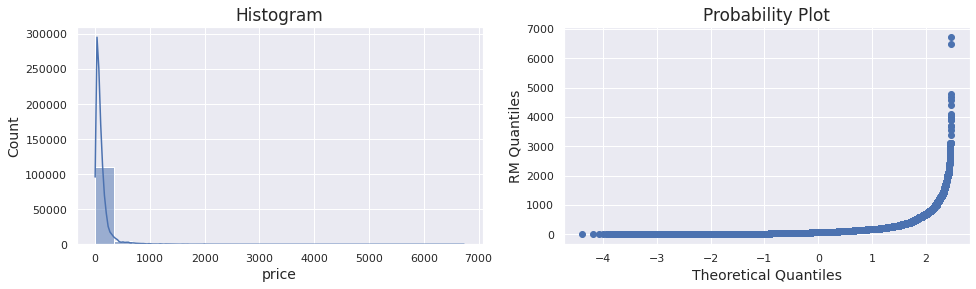

**2. Plot for freight_value**

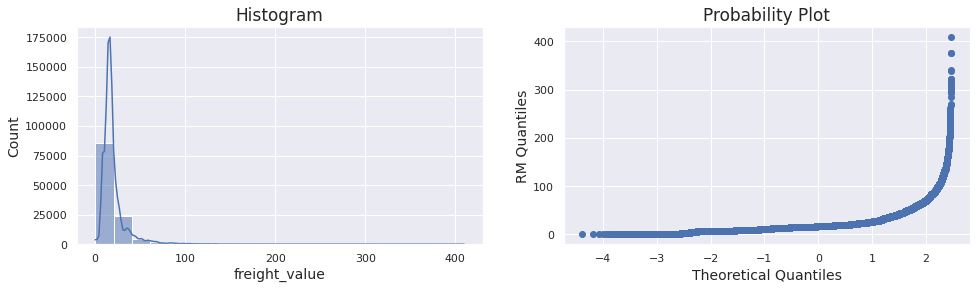

**3. Plot for order_item_id**

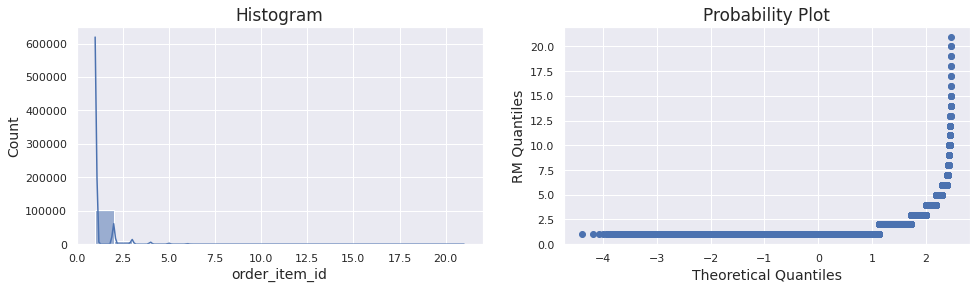

**4. Plot for product_weight_g**

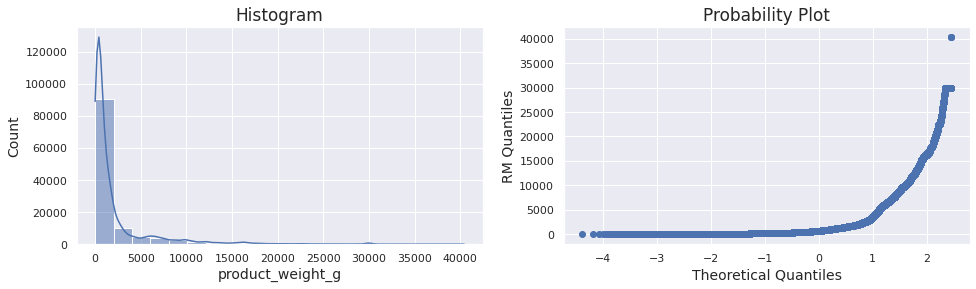

**5. Plot for product_length_cm**

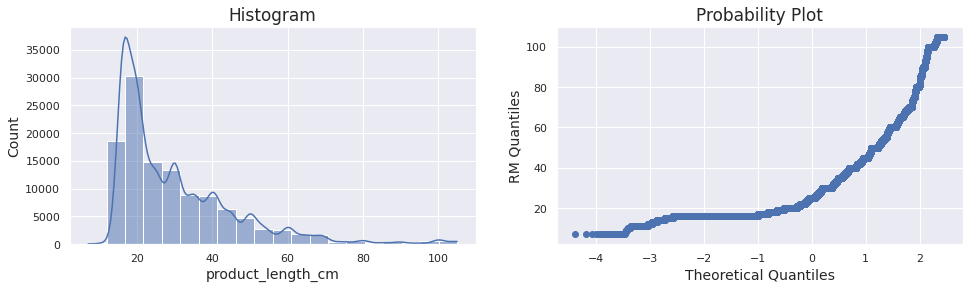

**6. Plot for product_height_cm**

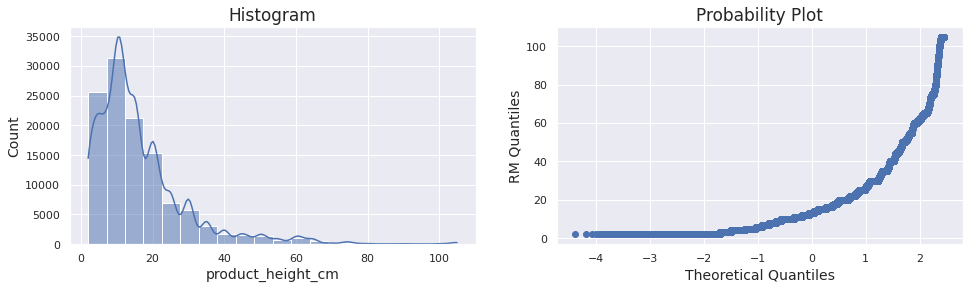

**7. Plot for product_width_cm**

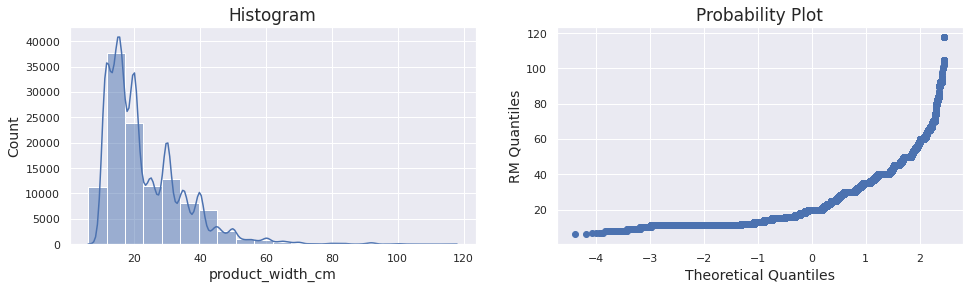

**8. Plot for product_name_lenght**

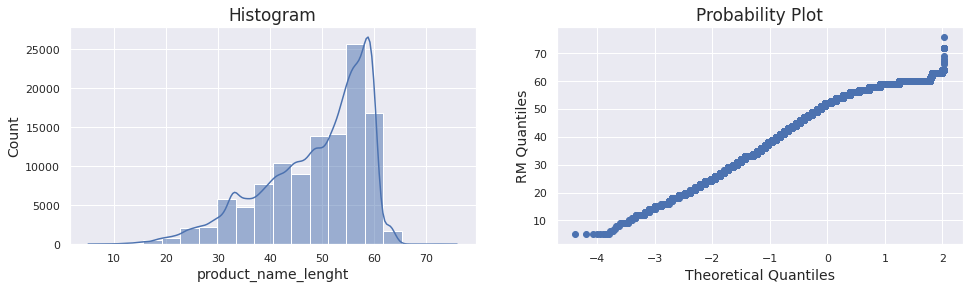

**9. Plot for product_description_lenght**

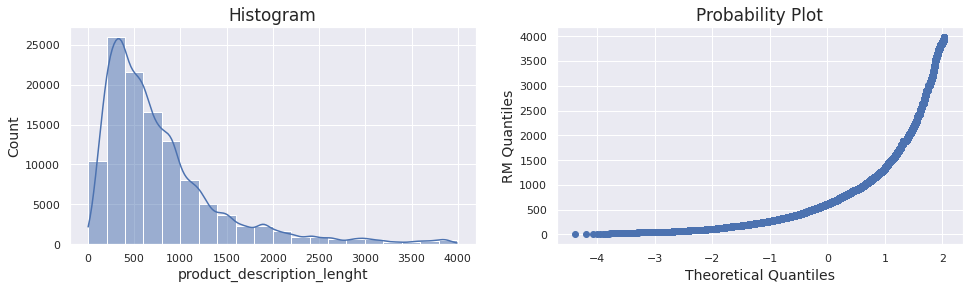

**10. Plot for product_photos_qty**

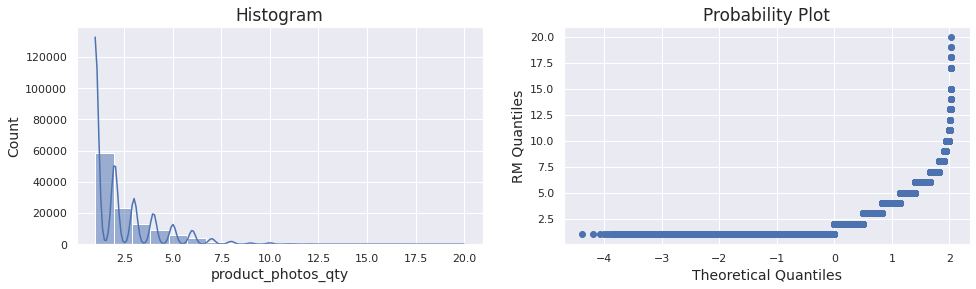

**11. Plot for payment_sequential**

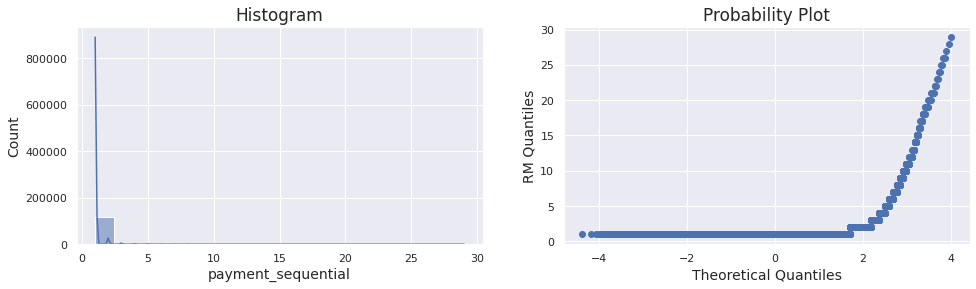

**12. Plot for payment_installments**

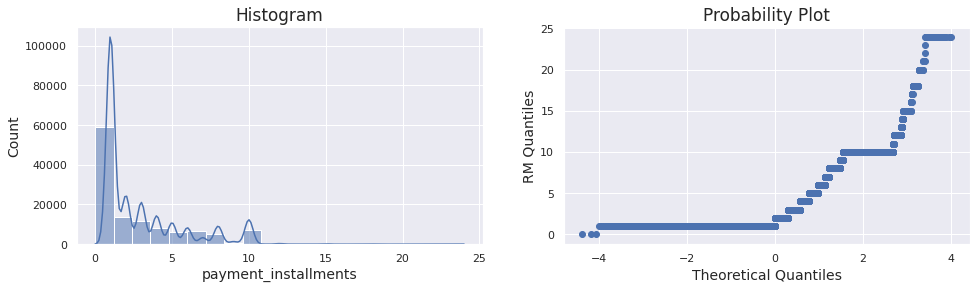

**13. Plot for payment_value**

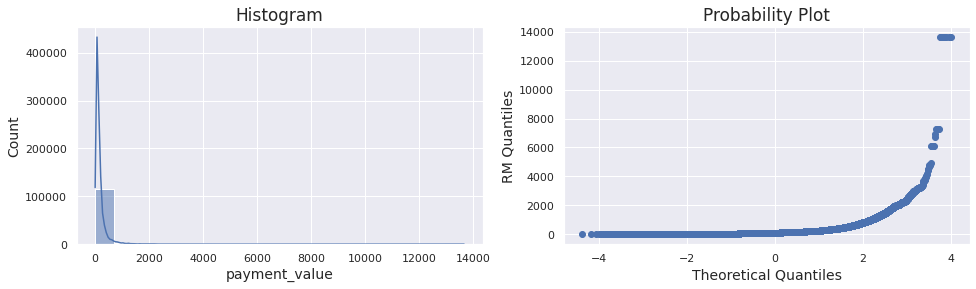

**14. Plot for review_score**

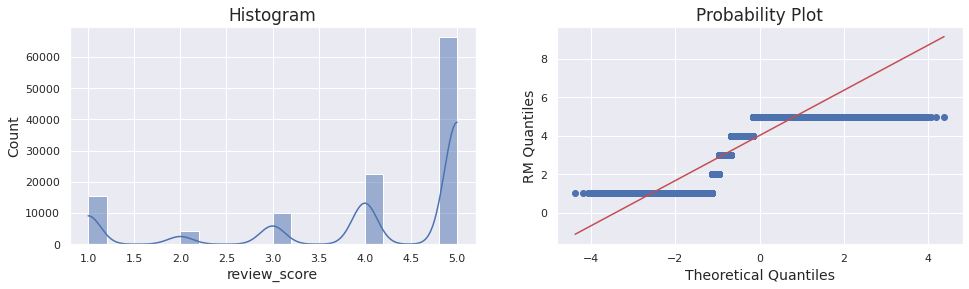

In [ ]:
eda.numerical_plots(orders, cont_columns, normality_check = True)

In [ ]:
fig = px.pie(orders['customer_state'], names = orders['customer_state'].value_counts().index,
             values = orders['customer_state'].value_counts().values,
             title = 'Customer State')
fig.show()

In [ ]:
fig = px.pie(orders['review_score'], names = orders['review_score'].value_counts().index,
             values = orders['review_score'].value_counts().values,
             title = 'Review Scores')
fig.show()

In [ ]:
items_reviews = pd.merge(order_reviews, order_items, how='left', on='order_id')
review_qty = items_reviews.groupby('review_score').size()
review_value = items_reviews.groupby('review_score')['price'].mean()

In [ ]:
trace0 = go.Bar(
    x=review_qty.index,
    y=review_qty.values,
    name='Number of orders',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    x=review_value.index,
    y=review_value.values,
    name='Product mean value',
    marker=dict(color='rgb(204,204,204)')
)
fig = make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Review Score')
fig['layout']['xaxis1'].update(title='review score', domain=[0, 0.40], tickmode = 'linear')
fig['layout']['xaxis2'].update(title='review score', domain=[0.6, 1], tickmode = 'linear')
iplot(fig);

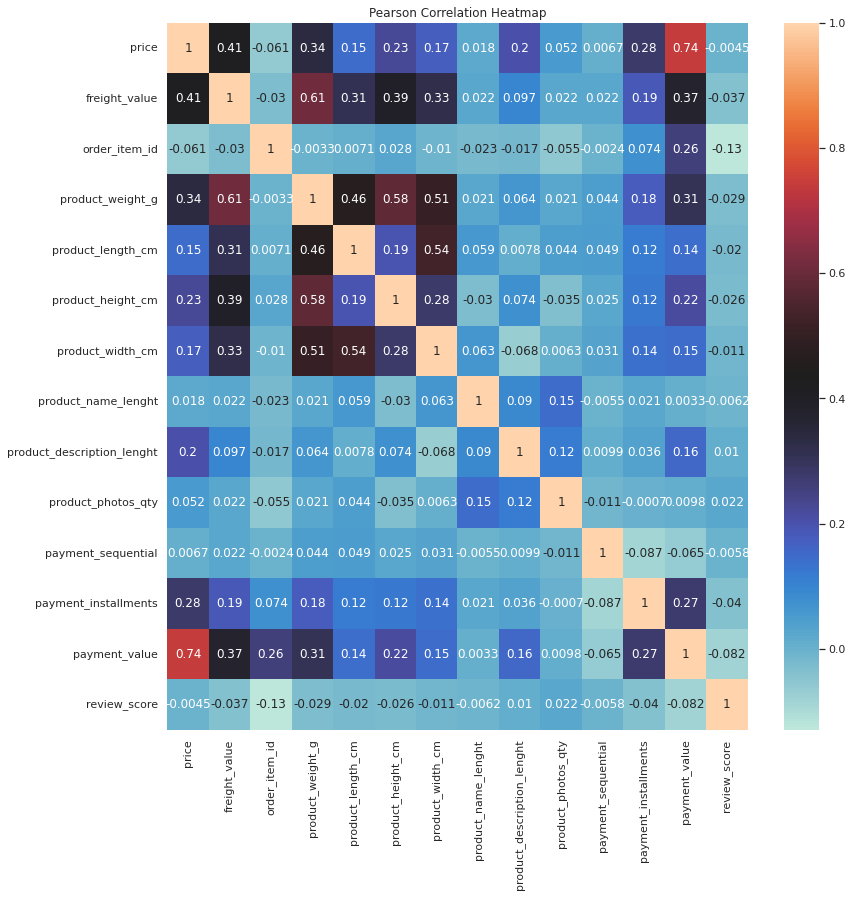

In [ ]:
fig, ax = plt.subplots(figsize = (13, 13))
plt.title("Pearson Correlation Heatmap")
sns.heatmap(orders.corr(method = 'pearson'), annot = True, cmap = 'icefire')
plt.show()

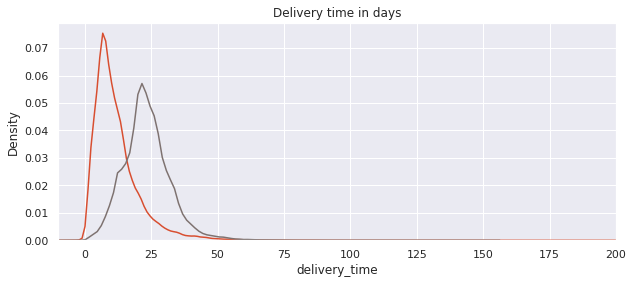

In [ ]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['delivery_time'] = (orders_df['order_delivered_customer_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
orders_df['estimated_delivery_time'] = (orders_df['order_estimated_delivery_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")
plt.xlim(-10, 200)

ax1 = sns.kdeplot(orders_df['delivery_time'].dropna(), color="#D84E30", label='Delivery time')
ax2 = sns.kdeplot(orders_df['estimated_delivery_time'].dropna(), color="#7E7270", label='Estimated delivery time')

In [ ]:
top_ordersbyvalue_cities = orders.groupby("customer_city")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
top_ordersbyvalue_cities["% of Total Payments"] = (top_ordersbyvalue_cities["payment_value"] / top_ordersbyvalue_cities["payment_value"].sum()) * 100
top_ordersbyvalue_cities["Cum % of Total Payments"] = top_ordersbyvalue_cities["% of Total Payments"].cumsum() 

In [ ]:
fig = px.bar(top_ordersbyvalue_cities[:10], x = "% of Total Payments", y = "customer_city", 
             title = "Highest 10 cities by revenue generation")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [ ]:
fig = px.bar(top_ordersbyvalue_cities[-10:], x = "% of Total Payments", y = "customer_city", 
             title = "Lowest 10 cities by revenue generation")
fig.show()

In [ ]:
plt.figure(figsize=(6,6))
reviewsocres = orders.groupby("product_category_name_english")["review_score"].agg(["mean", "count"]).sort_values(by="mean",ascending=False)
bestrated = reviewsocres[reviewsocres["count"]>=30][:10]
bestrated
fig = px.bar(bestrated, x = bestrated.values[0:, 0], y = bestrated.index, 
             title = "Highest 10 rated items categories")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

<Figure size 432x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
worstrated = reviewsocres[reviewsocres["count"]>=30].sort_values(by='mean')[:10]
fig = px.bar(worstrated, x = worstrated.values[0:, 0], y = worstrated.index, 
             title = "Lowest 10 rated items categories")
fig.show()

<Figure size 432x432 with 0 Axes>

In [ ]:
merged_groups = orders.groupby('customer_city')['payment_value'].sum().reset_index().sort_values('payment_value', ascending = False)
plt.figure(figsize = (12, 12))
fig = px.bar(merged_groups[:10], x = "customer_city", y='payment_value', title = 'Payment Value on the basis of State')
fig.show()

<Figure size 864x864 with 0 Axes>

In [ ]:
merged_groups = orders.groupby('product_category_name_english')['payment_value'].sum().reset_index().sort_values('payment_value', ascending = False)
plt.figure(figsize = (15, 15))
fig = px.bar(merged_groups[:10], x = "product_category_name_english", y='payment_value', title = 'Payment Value on the basis Product Value')
fig.show()

<Figure size 1080x1080 with 0 Axes>

In [ ]:
scorevstime = orders.groupby(pd.to_datetime(orders.order_purchase_timestamp).dt.year)["review_score"].mean().dropna()
plt.figure(figsize=(6,6))
fig = px.bar(scorevstime, x = scorevstime.index , y = scorevstime.values, 
             title = "Mean Review Score on Yearly Basis")
fig.show()

<Figure size 432x432 with 0 Axes>

##4. Feature Engineering

In [ ]:
orders.head(10)

,customer_unique_id,order_status,price,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_city,...,product_name_lenght,product_description_lenght,product_photos_qty,payment_sequential,payment_type,payment_installments,payment_value,review_creation_date,review_answer_timestamp,review_score
0,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,osasco,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
1,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,osasco,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
2,64190b91b656ab8f37eb89b93dc84584,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,nova odessa,...,47.0,493.0,1.0,1.0,credit_card,1.0,88.09,2018-03-11,2018-03-11,5
3,1d47144362c14e94ccdd213e8ec277d5,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,santo antonio de jesus,...,59.0,1893.0,1.0,1.0,credit_card,1.0,194.12,2018-02-18,2018-02-18,5
4,c8cf6cb6b838dc7a33ed199b825e8616,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,gravatal,...,33.0,2188.0,2.0,1.0,credit_card,1.0,222.84,2017-04-21,2017-04-21,5
5,d16000272660a1fef81482ad75ba572a,delivered,1199.00,2018-02-10,2018-02-10,2018-03-09,2018-02-28,134.25,1.0,curitibanos,...,48.0,562.0,5.0,1.0,credit_card,10.0,1333.25,2018-03-02,2018-03-02,5
6,bda84be75dfc9588ae63cfe827080b9b,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,1.0,sao paulo,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
7,bda84be75dfc9588ae63cfe827080b9b,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,2.0,sao paulo,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
8,bda84be75dfc9588ae63cfe827080b9b,delivered,119.00,2018-04-06,2018-04-09,2018-05-03,2018-04-12,4.40,3.0,sao paulo,...,30.0,568.0,1.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
9,bda84be75dfc9588ae63cfe827080b9b,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,4.0,sao paulo,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1


In [ ]:
orders.shape

(118146, 26)

In [ ]:
cat_columns

['customer_unique_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_estimated_delivery_date',
 'order_delivered_customer_date',
 'customer_city',
 'customer_state',
 'product_category_name_english',
 'payment_type',
 'review_creation_date',
 'review_answer_timestamp']

In [ ]:
cont_columns

['price',
 'freight_value',
 'order_item_id',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'payment_sequential',
 'payment_installments',
 'payment_value',
 'review_score']

In [ ]:
skew_data = orders.skew(axis = 0, skipna = True)
skew_data

<ipython-input-53-f22a5d68bcc6>:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



price                          7.652406
freight_value                  5.552176
order_item_id                  7.181680
product_weight_g               3.582198
product_length_cm              1.745291
product_height_cm              2.239916
product_width_cm               1.705233
product_name_lenght           -0.905520
product_description_lenght     2.011468
product_photos_qty             1.910438
payment_sequential            15.732593
payment_installments           1.622332
payment_value                 14.127975
review_score                  -1.245767
dtype: float64

In [ ]:
orders['delivery_time'] = orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']

In [ ]:
def delivery_time_days(x): #regarding delivery time
    if x >= 7 :
        return 'Slow'
    elif 4<=x<=6:
        return 'Medium'
    else:
        return 'Fast'
    
orders['delivery_time_class'] = orders['delivery_time'].dt.days.apply(lambda x: delivery_time_days(x))

In [ ]:
orders['delivery_time_class']

0         Medium
1         Medium
2           Slow
3           Slow
4           Slow
           ...  
118141      Slow
118142    Medium
118143      Fast
118144      Slow
118145      Fast
Name: delivery_time_class, Length: 118146, dtype: object

In [ ]:
fig = px.pie(orders['delivery_time_class'], names = orders['delivery_time_class'].value_counts().index,
             values = orders['delivery_time_class'].value_counts().values,
             title = 'Delivery Time')
fig.show()

In [ ]:
orders['review_upload_time'] = orders['review_answer_timestamp'] - orders['review_creation_date']

In [ ]:
def respone_by_seller(x): #regarding seller response time
    if x > 3 :
        return 'Slow'
    elif x == 0 :
        return 'On Time'
    else:
        return 'Fast'
    
orders['seller_response'] = orders['review_upload_time'].dt.days.apply(lambda x: respone_by_seller(x))

In [ ]:
orders['seller_response']

0         On Time
1         On Time
2         On Time
3         On Time
4         On Time
           ...   
118141    On Time
118142    On Time
118143    On Time
118144    On Time
118145    On Time
Name: seller_response, Length: 118146, dtype: object

In [ ]:
fig = px.pie(orders['seller_response'], names = orders['seller_response'].value_counts().index,
             values = orders['seller_response'].value_counts().values,
             title = 'Seller Response')
fig.show()

In [ ]:
def payment_vals(x): #regarding price of the product
    if x >= 700.00:
        return 'Expensive'
    elif 200.00<=x<=699.99:
        return 'Medium'
    else:
        return 'Cheap'
    
orders['payment_value_class'] = orders.payment_value.apply(lambda x: payment_vals(x))

In [ ]:
orders['payment_value_class']

0         Medium
1         Medium
2          Cheap
3          Cheap
4         Medium
           ...  
118141    Medium
118142    Medium
118143    Medium
118144     Cheap
118145     Cheap
Name: payment_value_class, Length: 118146, dtype: object

In [ ]:
fig = px.pie(orders['payment_value_class'], names = orders['payment_value_class'].value_counts().index,
             values = orders['payment_value_class'].value_counts().values,
             title = 'Payment Class')
fig.show()

In [ ]:
def customer_debentures(x): #regarding installments due
    if x == 1:
        return False
    else:
        return True

orders['customer_debt'] = orders.payment_installments.apply(lambda x: customer_debentures(x)) 

In [ ]:
orders['customer_debt']

0          True
1          True
2         False
3         False
4         False
          ...  
118141     True
118142    False
118143     True
118144    False
118145    False
Name: customer_debt, Length: 118146, dtype: bool

In [ ]:
fig = px.pie(orders['customer_debt'], names = orders['customer_debt'].value_counts().index,
             values = orders['customer_debt'].value_counts().values,
             title = 'Installments')
fig.show()

In [ ]:
def customer_cash_based_payment(x): #regarding customer payment method
    if x == ('boleto'):
        return True
    elif x == ('debit_card'):
        return True
    else:
        return False
    
orders['cash_customer_payment'] = orders.payment_type.apply(lambda x: customer_cash_based_payment(x)) 

In [ ]:
orders['cash_customer_payment'] 

0         False
1         False
2         False
3         False
4         False
          ...  
118141    False
118142    False
118143    False
118144    False
118145     True
Name: cash_customer_payment, Length: 118146, dtype: bool

In [ ]:
fig = px.pie(orders['cash_customer_payment'], names = orders['cash_customer_payment'].value_counts().index,
             values = orders['cash_customer_payment'].value_counts().values,
             title = 'Customer Payment')
fig.show()

In [ ]:
def product_weight(x): #regarding product weight
    if x > 3700:
        return 'Heavy'
    elif 1700<=x<=3700:
        return 'Medium'
    else:
        return 'Light'
    
orders['product_width_class'] = orders.product_weight_g.apply(lambda x: product_weight(x))

In [ ]:
orders['product_width_class']

0          Light
1          Light
2          Light
3          Heavy
4          Heavy
           ...  
118141     Heavy
118142    Medium
118143     Heavy
118144     Light
118145     Light
Name: product_width_class, Length: 118146, dtype: object

In [ ]:
fig = px.pie(orders['product_width_class'], names = orders['product_width_class'].value_counts().index,
             values = orders['product_width_class'].value_counts().values,
             title = 'Product Class')
fig.show()

In [ ]:
orders

,customer_unique_id,order_status,price,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_city,...,review_answer_timestamp,review_score,delivery_time,delivery_time_class,review_upload_time,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,osasco,...,2018-01-18,4,6 days,Medium,0 days,On Time,Medium,True,False,Light
1,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,osasco,...,2018-01-18,4,6 days,Medium,0 days,On Time,Medium,True,False,Light
2,64190b91b656ab8f37eb89b93dc84584,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,nova odessa,...,2018-03-11,5,9 days,Slow,0 days,On Time,Cheap,False,False,Light
3,1d47144362c14e94ccdd213e8ec277d5,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,santo antonio de jesus,...,2018-02-18,5,13 days,Slow,0 days,On Time,Cheap,False,False,Heavy
4,c8cf6cb6b838dc7a33ed199b825e8616,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,gravatal,...,2017-04-21,5,11 days,Slow,0 days,On Time,Medium,False,False,Heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,50605c81f77a2171191dffee444613b2,delivered,226.77,2018-06-27,2018-06-28,2018-07-20,2018-07-06,61.20,1.0,goiania,...,2018-07-14,5,9 days,Slow,0 days,On Time,Medium,True,False,Heavy
118142,597cbb334f18a671472f7e16648228b4,delivered,199.99,2017-12-03,2017-12-03,2017-12-20,2017-12-08,9.77,1.0,rio de janeiro,...,2017-12-11,5,5 days,Medium,0 days,On Time,Medium,False,False,Medium
118143,c860357db400d72a2497064f8376fba9,delivered,215.97,2018-03-18,2018-03-18,2018-04-06,2018-03-21,15.59,1.0,lavras,...,2018-03-23,5,3 days,Fast,0 days,On Time,Medium,True,False,Heavy
118144,96ac4cb74918d3ace141d3d3ddc1ff02,delivered,50.95,2018-06-22,2018-06-22,2018-07-16,2018-06-30,15.46,1.0,betim,...,2018-07-02,4,8 days,Slow,0 days,On Time,Cheap,False,False,Light


In [ ]:
orders = orders.rename(columns = {'order_purchase_timestamp' : 'last_transaction'})

In [ ]:
cust_state = orders.groupby('customer_state', sort = False)['review_score'].value_counts()
cust_state

customer_state  review_score
SP              5               29311
                4                9417
                1                5535
                3                4034
                2                1625
                                ...  
AP              5                  44
                4                  25
                3                   8
                1                   4
                2                   2
Name: review_score, Length: 135, dtype: int64

In [ ]:
cust_state.index.values

array([('SP', 5), ('SP', 4), ('SP', 1), ('SP', 3), ('SP', 2), ('BA', 5),
       ('BA', 4), ('BA', 1), ('BA', 3), ('BA', 2), ('SC', 5), ('SC', 4),
       ('SC', 1), ('SC', 3), ('SC', 2), ('RJ', 5), ('RJ', 1), ('RJ', 4),
       ('RJ', 3), ('RJ', 2), ('MG', 5), ('MG', 4), ('MG', 1), ('MG', 3),
       ('MG', 2), ('ES', 5), ('ES', 4), ('ES', 1), ('ES', 3), ('ES', 2),
       ('DF', 5), ('DF', 4), ('DF', 1), ('DF', 3), ('DF', 2), ('RS', 5),
       ('RS', 4), ('RS', 1), ('RS', 3), ('RS', 2), ('PE', 5), ('PE', 4),
       ('PE', 1), ('PE', 3), ('PE', 2), ('PI', 5), ('PI', 4), ('PI', 1),
       ('PI', 3), ('PI', 2), ('GO', 5), ('GO', 4), ('GO', 1), ('GO', 3),
       ('GO', 2), ('PR', 5), ('PR', 4), ('PR', 1), ('PR', 3), ('PR', 2),
       ('MT', 5), ('MT', 4), ('MT', 1), ('MT', 3), ('MT', 2), ('PA', 5),
       ('PA', 4), ('PA', 1), ('PA', 3), ('PA', 2), ('AC', 5), ('AC', 4),
       ('AC', 3), ('AC', 2), ('AC', 1), ('MA', 5), ('MA', 1), ('MA', 4),
       ('MA', 3), ('MA', 2), ('RO', 5), ('RO', 4), 

In [ ]:
state = []
for t in cust_state.index.values:
     state.append(t[0])

all_state = list(unique_everseen(state))
all_state 

['SP',
 'BA',
 'SC',
 'RJ',
 'MG',
 'ES',
 'DF',
 'RS',
 'PE',
 'PI',
 'GO',
 'PR',
 'MT',
 'PA',
 'AC',
 'MA',
 'RO',
 'SE',
 'AM',
 'PB',
 'RN',
 'TO',
 'CE',
 'AL',
 'MS',
 'RR',
 'AP']

In [ ]:
cust_st = all_state
rate = (5, 4, 1, 3, 2)
index = pd.MultiIndex.from_product(
    [cust_st, rate], 
   names=['Customer State', 'Ratings']
)

#values = [36927, 12995, 2836, 1200, 3057, 1252, 10736, 4566, 9847, 3867]
values = cust_state.values
data = pd.DataFrame(data={'val': values}, index=index).reset_index()
data

,Customer State,Ratings,val
0,SP,5,29311
1,SP,4,9417
2,SP,1,5535
3,SP,3,4034
4,SP,2,1625
...,...,...,...
130,AP,5,44
131,AP,4,25
132,AP,1,8
133,AP,3,4


In [ ]:
plt.figure(figsize=(10,10))
fig = px.bar(data, x = "Customer State", y = "val", color = "Ratings", title = "State wise Review Scores")
fig.show()

<Figure size 720x720 with 0 Axes>

In [ ]:
orders

,customer_unique_id,order_status,price,last_transaction,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_city,...,review_answer_timestamp,review_score,delivery_time,delivery_time_class,review_upload_time,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,osasco,...,2018-01-18,4,6 days,Medium,0 days,On Time,Medium,True,False,Light
1,68a5590b9926689be4e10f4ae2db21a8,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,osasco,...,2018-01-18,4,6 days,Medium,0 days,On Time,Medium,True,False,Light
2,64190b91b656ab8f37eb89b93dc84584,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,nova odessa,...,2018-03-11,5,9 days,Slow,0 days,On Time,Cheap,False,False,Light
3,1d47144362c14e94ccdd213e8ec277d5,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,santo antonio de jesus,...,2018-02-18,5,13 days,Slow,0 days,On Time,Cheap,False,False,Heavy
4,c8cf6cb6b838dc7a33ed199b825e8616,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,gravatal,...,2017-04-21,5,11 days,Slow,0 days,On Time,Medium,False,False,Heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,50605c81f77a2171191dffee444613b2,delivered,226.77,2018-06-27,2018-06-28,2018-07-20,2018-07-06,61.20,1.0,goiania,...,2018-07-14,5,9 days,Slow,0 days,On Time,Medium,True,False,Heavy
118142,597cbb334f18a671472f7e16648228b4,delivered,199.99,2017-12-03,2017-12-03,2017-12-20,2017-12-08,9.77,1.0,rio de janeiro,...,2017-12-11,5,5 days,Medium,0 days,On Time,Medium,False,False,Medium
118143,c860357db400d72a2497064f8376fba9,delivered,215.97,2018-03-18,2018-03-18,2018-04-06,2018-03-21,15.59,1.0,lavras,...,2018-03-23,5,3 days,Fast,0 days,On Time,Medium,True,False,Heavy
118144,96ac4cb74918d3ace141d3d3ddc1ff02,delivered,50.95,2018-06-22,2018-06-22,2018-07-16,2018-06-30,15.46,1.0,betim,...,2018-07-02,4,8 days,Slow,0 days,On Time,Cheap,False,False,Light


In [ ]:
orders.columns

Index(['customer_unique_id', 'order_status', 'price', 'last_transaction',
       'order_approved_at', 'order_estimated_delivery_date',
       'order_delivered_customer_date', 'freight_value', 'order_item_id',
       'customer_city', 'customer_state', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_creation_date', 'review_answer_timestamp',
       'review_score', 'delivery_time', 'delivery_time_class',
       'review_upload_time', 'seller_response', 'payment_value_class',
       'customer_debt', 'cash_customer_payment', 'product_width_class'],
      dtype='object')

In [ ]:
orders.drop(columns=['price', 'last_transaction', 
       'order_approved_at', 'order_estimated_delivery_date',
       'order_delivered_customer_date', 'freight_value', 'product_weight_g',
      'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'product_name_lenght',
       'product_description_lenght',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_creation_date', 'review_answer_timestamp', 'review_upload_time', 'delivery_time'], inplace = True)

In [ ]:
#sum(orders.duplicated())

In [ ]:
#orders = orders.drop_duplicates()

In [ ]:
#log_transform = np.log(orders[cont_columns] + 1)
#log_transform

In [ ]:
#orders = orders.drop(columns = cont_columns, axis = 1)

In [ ]:
#orders.head(10)

In [ ]:
#orders = pd.concat([orders, log_transform], axis = 1)

In [ ]:
#orders.head(10)

In [ ]:
#orders.shape

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_unique_id     118146 non-null  object 
 1   order_status           118146 non-null  object 
 2   order_item_id          117332 non-null  float64
 3   customer_city          118146 non-null  object 
 4   customer_state         118146 non-null  object 
 5   product_photos_qty     115637 non-null  float64
 6   review_score           118146 non-null  int64  
 7   delivery_time_class    118146 non-null  object 
 8   seller_response        118146 non-null  object 
 9   payment_value_class    118146 non-null  object 
 10  customer_debt          118146 non-null  bool   
 11  cash_customer_payment  118146 non-null  bool   
 12  product_width_class    118146 non-null  object 
dtypes: bool(2), float64(2), int64(1), object(8)
memory usage: 11.0+ MB


In [ ]:
for c in orders.select_dtypes(include = ([np.number])).columns.values:
  orders[c].fillna(orders[c].median(), inplace=True)

for c in orders.select_dtypes(include = (['object'])).columns.values:
  orders[c].fillna(orders[c].mode().values[0], inplace=True)  

In [ ]:
eda.numerical_check_outliers(orders, list(orders.select_dtypes(include=[np.number]).columns.values), tol=1.5, print_vars = False)

,lower_bound_outliers,upper_bound_outliers,total_outliers,perc_outliers
review_score,19590,0,19590,16.581179
order_item_id,0,14468,14468,12.245865
product_photos_qty,0,3184,3184,2.694971


In [ ]:
outliers = eda.numerical_check_outliers(orders, list(orders.select_dtypes(include=[np.number]).columns.values), tol=1.5, print_vars = False)
per = outliers['perc_outliers']
tot = outliers['total_outliers']

In [ ]:
fig = px.bar(data, x = per.index, y = per.values, title = "Outliers on Basis of Percentage")
fig.show()

In [ ]:
fig = px.bar(data, x = tot.index, y = tot.values, title = "Outliers on Basis of Count")
fig.show()

In [ ]:
elpenv = EllipticEnvelope(contamination=0.025, random_state=1)
  # Returns 1 of inliers, -1 for outliers
pred = elpenv.fit_predict(orders[list(orders.select_dtypes(include=[np.number]).columns.values)])

anom_index = np.where(pred==-1)
rem = orders.loc[anom_index]

rem

,customer_unique_id,order_status,order_item_id,customer_city,customer_state,product_photos_qty,review_score,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
8,bda84be75dfc9588ae63cfe827080b9b,delivered,3.0,sao paulo,SP,1.0,1,Medium,On Time,Medium,False,False,Light
9,bda84be75dfc9588ae63cfe827080b9b,delivered,4.0,sao paulo,SP,2.0,1,Medium,On Time,Medium,False,False,Light
18,92dcd4992a1c796d78efe76628436880,delivered,4.0,belo horizonte,MG,1.0,5,Slow,On Time,Medium,False,True,Light
19,92dcd4992a1c796d78efe76628436880,delivered,5.0,belo horizonte,MG,1.0,5,Slow,On Time,Medium,False,True,Light
57,3b81cc8417be691f3159596da7e08a3c,delivered,3.0,corrente,PI,1.0,1,Slow,On Time,Medium,True,False,Light
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117934,58703c8104494f333026acd373ca9027,delivered,3.0,sorriso,MT,1.0,1,Slow,On Time,Cheap,True,False,Light
118048,75d0154ed5d24c347fd4c5bccc050e1c,delivered,3.0,sao paulo,SP,2.0,1,Slow,On Time,Medium,True,False,Medium
118114,c9ae1d598a33315fdace01e3bfefc5ea,delivered,4.0,sao carlos,SP,2.0,3,Slow,On Time,Medium,False,False,Light
118115,c9ae1d598a33315fdace01e3bfefc5ea,delivered,5.0,sao carlos,SP,2.0,3,Slow,On Time,Medium,False,False,Light


In [ ]:
orders.drop(index = rem.index, axis = 0, inplace = True)

In [ ]:
orders.shape

(115155, 13)

In [ ]:
orders

,customer_unique_id,order_status,order_item_id,customer_city,customer_state,product_photos_qty,review_score,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,68a5590b9926689be4e10f4ae2db21a8,delivered,1.0,osasco,SP,1.0,4,Medium,On Time,Medium,True,False,Light
1,68a5590b9926689be4e10f4ae2db21a8,delivered,2.0,osasco,SP,1.0,4,Medium,On Time,Medium,True,False,Light
2,64190b91b656ab8f37eb89b93dc84584,delivered,1.0,nova odessa,SP,1.0,5,Slow,On Time,Cheap,False,False,Light
3,1d47144362c14e94ccdd213e8ec277d5,delivered,1.0,santo antonio de jesus,BA,1.0,5,Slow,On Time,Cheap,False,False,Heavy
4,c8cf6cb6b838dc7a33ed199b825e8616,delivered,1.0,gravatal,SC,2.0,5,Slow,On Time,Medium,False,False,Heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,50605c81f77a2171191dffee444613b2,delivered,1.0,goiania,GO,1.0,5,Slow,On Time,Medium,True,False,Heavy
118142,597cbb334f18a671472f7e16648228b4,delivered,1.0,rio de janeiro,RJ,1.0,5,Medium,On Time,Medium,False,False,Medium
118143,c860357db400d72a2497064f8376fba9,delivered,1.0,lavras,MG,3.0,5,Fast,On Time,Medium,True,False,Heavy
118144,96ac4cb74918d3ace141d3d3ddc1ff02,delivered,1.0,betim,MG,5.0,4,Slow,On Time,Cheap,False,False,Light


In [ ]:
X = orders.drop('review_score', axis = 1)
y = orders['review_score']

In [ ]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [ ]:
X.shape, y.shape

((115155, 12), (115155,))

In [ ]:
X.head(10)

,customer_unique_id,order_status,order_item_id,customer_city,customer_state,product_photos_qty,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,68a5590b9926689be4e10f4ae2db21a8,delivered,1.0,osasco,SP,1.0,Medium,On Time,Medium,True,False,Light
1,68a5590b9926689be4e10f4ae2db21a8,delivered,2.0,osasco,SP,1.0,Medium,On Time,Medium,True,False,Light
2,64190b91b656ab8f37eb89b93dc84584,delivered,1.0,nova odessa,SP,1.0,Slow,On Time,Cheap,False,False,Light
3,1d47144362c14e94ccdd213e8ec277d5,delivered,1.0,santo antonio de jesus,BA,1.0,Slow,On Time,Cheap,False,False,Heavy
4,c8cf6cb6b838dc7a33ed199b825e8616,delivered,1.0,gravatal,SC,2.0,Slow,On Time,Medium,False,False,Heavy
5,d16000272660a1fef81482ad75ba572a,delivered,1.0,curitibanos,SC,5.0,Slow,On Time,Expensive,True,False,Heavy
6,bda84be75dfc9588ae63cfe827080b9b,delivered,1.0,sao paulo,SP,2.0,Medium,On Time,Medium,False,False,Light
7,bda84be75dfc9588ae63cfe827080b9b,delivered,2.0,sao paulo,SP,2.0,Medium,On Time,Medium,False,False,Light
10,dcd4940b3f96a3e2b73d8f73387230cf,delivered,1.0,sao paulo,SP,1.0,Slow,On Time,Cheap,True,False,Light
11,c7b4fb0959a97e7033ff9bef3b1e2ba9,delivered,1.0,resende,RJ,9.0,Medium,On Time,Cheap,True,False,Heavy


In [ ]:
y.head(10)

0     4
1     4
2     5
3     5
4     5
5     5
6     1
7     1
10    5
11    5
Name: review_score, dtype: int64

In [ ]:
X.dtypes

customer_unique_id        object
order_status              object
order_item_id            float64
customer_city             object
customer_state            object
product_photos_qty       float64
delivery_time_class       object
seller_response           object
payment_value_class       object
customer_debt               bool
cash_customer_payment       bool
product_width_class       object
dtype: object

In [ ]:
X_num_col = X.select_dtypes(include = ([np.number])).columns.values
X_num_cat = X.select_dtypes(include = (['object'])).columns.values

In [ ]:
full_pipe = ColumnTransformer(transformers = [('ord_enc', OrdinalEncoder(), X_num_cat), ('std_scl', StandardScaler(), X_num_col)],
                                remainder = 'passthrough')
  
X_pipe = full_pipe.fit_transform(X)

X_pipe

array([[ 3.89900000e+04,  3.00000000e+00,  2.59200000e+03, ...,
        -7.09935911e-01,  1.00000000e+00,  0.00000000e+00],
       [ 3.89900000e+04,  3.00000000e+00,  2.59200000e+03, ...,
        -7.09935911e-01,  1.00000000e+00,  0.00000000e+00],
       [ 3.72960000e+04,  3.00000000e+00,  2.51600000e+03, ...,
        -7.09935911e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.45090000e+04,  3.00000000e+00,  2.08000000e+03, ...,
         5.19825137e-01,  1.00000000e+00,  0.00000000e+00],
       [ 5.59710000e+04,  3.00000000e+00,  4.70000000e+02, ...,
         1.74958619e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.49960000e+04,  3.00000000e+00,  1.52900000e+03, ...,
        -9.50553870e-02,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
full_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord_enc', OrdinalEncoder(),
                                 array(['customer_unique_id', 'order_status', 'customer_city',
       'customer_state', 'delivery_time_class', 'seller_response',
       'payment_value_class', 'product_width_class'], dtype=object)),
                                ('std_scl', StandardScaler(),
                                 array(['order_item_id', 'product_photos_qty'], dtype=object))])

In [ ]:
X_feat = X_pipe

In [ ]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_feat, i) for i in range(X_feat.shape[1])]
vif["Features"] = X.columns
vif

/usr/local/lib/python3.9/dist-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning:

invalid value encountered in double_scalars



,vif,Features
0,3.881754,customer_unique_id
1,16.046310,order_status
2,5.100043,order_item_id
3,7.870864,customer_city
4,5.892392,customer_state
5,NaN,product_photos_qty
6,1.394713,delivery_time_class
7,4.431685,seller_response
8,1.037110,payment_value_class
9,1.004314,customer_debt


In [ ]:
vif_filtered = vif[vif['vif']<10]
vif_filtered

,vif,Features
0,3.881754,customer_unique_id
2,5.100043,order_item_id
3,7.870864,customer_city
4,5.892392,customer_state
6,1.394713,delivery_time_class
7,4.431685,seller_response
8,1.037110,payment_value_class
9,1.004314,customer_debt
10,2.809250,cash_customer_payment
11,1.730042,product_width_class


In [ ]:
cols = list(vif_filtered['Features'].unique())
X_filtered = X[cols]
X_filtered

,customer_unique_id,order_item_id,customer_city,customer_state,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,68a5590b9926689be4e10f4ae2db21a8,1.0,osasco,SP,Medium,On Time,Medium,True,False,Light
1,68a5590b9926689be4e10f4ae2db21a8,2.0,osasco,SP,Medium,On Time,Medium,True,False,Light
2,64190b91b656ab8f37eb89b93dc84584,1.0,nova odessa,SP,Slow,On Time,Cheap,False,False,Light
3,1d47144362c14e94ccdd213e8ec277d5,1.0,santo antonio de jesus,BA,Slow,On Time,Cheap,False,False,Heavy
4,c8cf6cb6b838dc7a33ed199b825e8616,1.0,gravatal,SC,Slow,On Time,Medium,False,False,Heavy
...,...,...,...,...,...,...,...,...,...,...
118141,50605c81f77a2171191dffee444613b2,1.0,goiania,GO,Slow,On Time,Medium,True,False,Heavy
118142,597cbb334f18a671472f7e16648228b4,1.0,rio de janeiro,RJ,Medium,On Time,Medium,False,False,Medium
118143,c860357db400d72a2497064f8376fba9,1.0,lavras,MG,Fast,On Time,Medium,True,False,Heavy
118144,96ac4cb74918d3ace141d3d3ddc1ff02,1.0,betim,MG,Slow,On Time,Cheap,False,False,Light


In [ ]:
X_cont = list(X_filtered.select_dtypes(include=[np.number]).columns.values)
X_cat = list(X_filtered.select_dtypes(include=['object']).columns.values)

In [ ]:
X_cols = X_filtered.select_dtypes(include = ([np.number])).columns.values
X_cats = X_filtered.select_dtypes(include = (['object'])).columns.values

In [ ]:
new_pipe = ColumnTransformer(transformers = [('ord_enc', OrdinalEncoder(), X_cats), ('std_scl', StandardScaler(), X_cols )],
                                remainder = 'passthrough')
  
X_pipe = new_pipe.fit_transform(X_filtered)

X_pipe

array([[ 3.89900000e+04,  2.59200000e+03,  2.50000000e+01, ...,
        -3.22050294e-01,  1.00000000e+00,  0.00000000e+00],
       [ 3.89900000e+04,  2.59200000e+03,  2.50000000e+01, ...,
         2.42259902e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.72960000e+04,  2.51600000e+03,  2.50000000e+01, ...,
        -3.22050294e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.45090000e+04,  2.08000000e+03,  1.00000000e+01, ...,
        -3.22050294e-01,  1.00000000e+00,  0.00000000e+00],
       [ 5.59710000e+04,  4.70000000e+02,  1.00000000e+01, ...,
        -3.22050294e-01,  0.00000000e+00,  0.00000000e+00],
       [ 2.49960000e+04,  1.52900000e+03,  2.50000000e+01, ...,
        -3.22050294e-01,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
new_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord_enc', OrdinalEncoder(),
                                 array(['customer_unique_id', 'customer_city', 'customer_state',
       'delivery_time_class', 'seller_response', 'payment_value_class',
       'product_width_class'], dtype=object)),
                                ('std_scl', StandardScaler(),
                                 array(['order_item_id'], dtype=object))])

In [ ]:
X_featured = X_pipe
X_featured

array([[ 3.89900000e+04,  2.59200000e+03,  2.50000000e+01, ...,
        -3.22050294e-01,  1.00000000e+00,  0.00000000e+00],
       [ 3.89900000e+04,  2.59200000e+03,  2.50000000e+01, ...,
         2.42259902e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.72960000e+04,  2.51600000e+03,  2.50000000e+01, ...,
        -3.22050294e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.45090000e+04,  2.08000000e+03,  1.00000000e+01, ...,
        -3.22050294e-01,  1.00000000e+00,  0.00000000e+00],
       [ 5.59710000e+04,  4.70000000e+02,  1.00000000e+01, ...,
        -3.22050294e-01,  0.00000000e+00,  0.00000000e+00],
       [ 2.49960000e+04,  1.52900000e+03,  2.50000000e+01, ...,
        -3.22050294e-01,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
X_featured.shape, y.shape

((115155, 10), (115155,))

In [ ]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_featured, y)

In [ ]:
fig = px.pie(y, names = y.value_counts().index,
             values = y.value_counts().values,
             title = 'Before SMOTE Process')
fig.show()

In [ ]:
fig = px.pie(y_sm, names = y_sm.value_counts().index,
             values = y_sm.value_counts().values,
             title = 'After SMOTE Process')
fig.show()

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
for train_index, test_index in split.split(X_sm, y_sm):
  X_train, X_test = X_sm[train_index], X_sm[test_index]
  y_train, y_test = y_sm[train_index], y_sm[test_index]

In [ ]:
X_train.shape, y_train.shape

((219274, 10), (219274,))

In [ ]:
X_test.shape, y_test.shape

((108001, 10), (108001,))

##5. Data Modelling



In [ ]:
def plot_feature_importance(importance, names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize = (10,8))
    sns.barplot(x = fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE') 
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


### K-Neighbours Classifier



In [ ]:
model_knn = KNeighborsClassifier(n_jobs = -1)
model_knn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1)

In [ ]:
train_acc_knn = model_knn.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_knn*100))

The Accuracy for Training Set is 71.19813566587922


In [ ]:
y_pred_knn = model_knn.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_pred_knn) 
print("The Accuracy for Test Set is {}".format(test_acc_knn*100))

The Accuracy for Test Set is 58.392977842797755


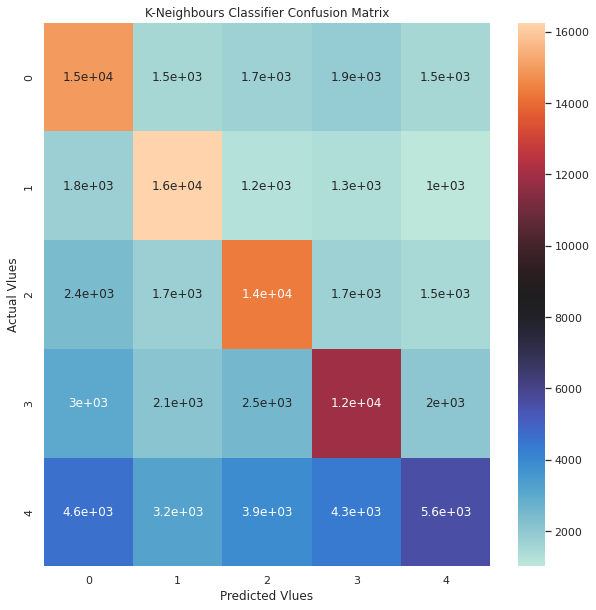

In [ ]:
plt.figure(figsize=(10,10))
plt.title("K-Neighbours Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_knn), annot = True, cmap ='icefire')
plt.ylabel("Actual Vlues")
plt.xlabel("Predicted Vlues")
plt.show()

####Hyperparamter Tuning

In [ ]:
def objective(trial):

    leaf_size =  trial.suggest_int('leaf_size', 1, 50)
    n_neighbors = trial.suggest_int('n_neighbors', 1, 100)
    p = trial.suggest_int('p', 1, 2)

    knc = KNeighborsClassifier(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p)

    score = cross_val_score(knc, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-03-27 04:06:28,990] A new study created in memory with name: no-name-6cedc57d-85df-47af-b87a-a6b76a688bea
[I 2023-03-27 04:06:44,814] Trial 0 finished with value: 0.4284912936795379 and parameters: {'leaf_size': 17, 'n_neighbors': 41, 'p': 1}. Best is trial 0 with value: 0.4284912936795379.
[I 2023-03-27 04:07:00,970] Trial 1 finished with value: 0.35461114108085884 and parameters: {'leaf_size': 30, 'n_neighbors': 90, 'p': 2}. Best is trial 0 with value: 0.4284912936795379.
[I 2023-03-27 04:07:14,732] Trial 2 finished with value: 0.4801617984722963 and parameters: {'leaf_size': 17, 'n_neighbors': 22, 'p': 1}. Best is trial 2 with value: 0.4801617984722963.
[I 2023-03-27 04:07:32,316] Trial 3 finished with value: 0.35819569123335143 and parameters: {'leaf_size': 48, 'n_neighbors': 89, 'p': 1}. Best is trial 2 with value: 0.4801617984722963.
[I 2023-03-27 04:07:45,159] Trial 4 finished with value: 0.47680526271507856 and parameters: {'leaf_size': 43, 'n_neighbors': 23, 'p': 1}. B

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.6278856632711947
Best hyperparameters: {'leaf_size': 34, 'n_neighbors': 1, 'p': 2}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
best_params = trial.params
best_params

{'leaf_size': 34, 'n_neighbors': 1, 'p': 2}

In [ ]:
model_knn_hp = KNeighborsClassifier(**best_params, n_jobs = -1)
model_knn_hp.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=34, n_jobs=-1, n_neighbors=1)

In [ ]:
y_pred_knn_hp = model_knn_hp.predict(X_test)

In [ ]:
train_acc_knn_hp = model_knn_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_knn_hp*100))

The Accuracy for Training Set is 99.8613606720359


In [ ]:
test_acc_knn_hp = accuracy_score(y_test, y_pred_knn_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_knn_hp*100))

The Accuracy for Test Set is 65.2808770289164


In [ ]:
print(classification_report(y_test, y_pred_knn_hp))

              precision    recall  f1-score   support

           1       0.68      0.69      0.68     21600
           2       0.75      0.77      0.76     21600
           3       0.68      0.70      0.69     21600
           4       0.62      0.65      0.63     21601
           5       0.51      0.46      0.48     21600

    accuracy                           0.65    108001
   macro avg       0.65      0.65      0.65    108001
weighted avg       0.65      0.65      0.65    108001



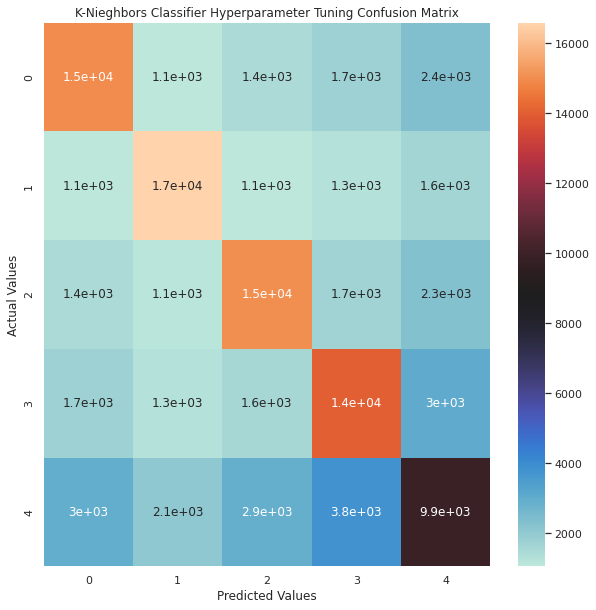

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("K-Nieghbors Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_knn_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

In [ ]:
input_data = [('1d47144362c14e94ccdd213e8ec277d5',	1.0,'santo antonio de jesus',	'BA', 'Slow','On Time', 'Cheap', False,	False, 'Heavy')]

In [ ]:
ex = pd.DataFrame(input_data, columns = ['customer_unique_id', 'order_item_id', 'customer_city', 'customer_state', 'delivery_time_class', 'seller_response', 'payment_value_class', 'customer_debt', 'cash_customer_payment', 'product_width_class'])
ex

,customer_unique_id,order_item_id,customer_city,customer_state,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,1d47144362c14e94ccdd213e8ec277d5,1.0,santo antonio de jesus,BA,Slow,On Time,Cheap,False,False,Heavy


In [ ]:
scale_ex = new_pipe.transform(ex)

In [ ]:
prdctn = model_knn_hp.predict(scale_ex)
prdctn

array([5])

### Random Forest Classifier (discarded)


In [ ]:
model_rfc=RandomForestClassifier(n_jobs= -1, max_depth = 15, min_samples_split= 5, 
                                 random_state= 10, n_estimators= 200)

model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       n_jobs=-1, random_state=10)

In [ ]:
y_pred_rfc = model_rfc.predict(X_test)

In [ ]:
train_acc_rfc = model_rfc.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_rfc*100))

The Accuracy for Training Set is 61.731441028120074


In [ ]:
test_acc_rfc = accuracy_score(y_test, y_pred_rfc)
print("The Accuracy for Test Set is {}".format(test_acc_rfc*100))

The Accuracy for Test Set is 51.40044999583338


In [ ]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           1       0.56      0.36      0.44     21600
           2       0.58      0.61      0.60     21600
           3       0.44      0.49      0.47     21600
           4       0.51      0.13      0.20     21601
           5       0.50      0.97      0.67     21600

    accuracy                           0.51    108001
   macro avg       0.52      0.51      0.47    108001
weighted avg       0.52      0.51      0.47    108001



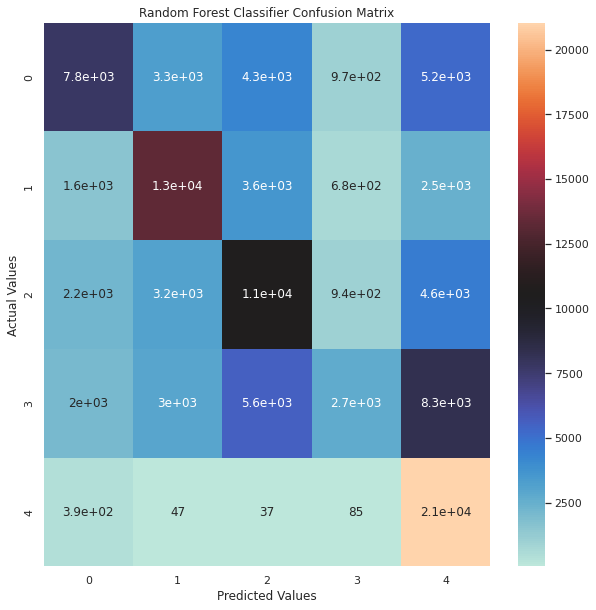

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Random Forest Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_rfc), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

####Hyperparamter Tuning

In [ ]:
def objective(trial):

    max_depth =  trial.suggest_int('max_depth', 20, 25, log = True)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)
    n_estimators = trial.suggest_int('n_estimators', 200, 400)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    
  

    rfc = RandomForestClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf,
                                 n_estimators = n_estimators, criterion = criterion,
                                 random_state = 10, n_jobs= -1)

    score = cross_val_score(rfc, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-03-26 14:53:41,110] A new study created in memory with name: no-name-51d6d2ee-fd8c-41a6-a4d1-f5c4caf57970
[I 2023-03-26 15:09:03,217] Trial 0 finished with value: 0.5412178445765436 and parameters: {'max_depth': 22, 'min_samples_leaf': 6, 'n_estimators': 287, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5412178445765436.
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[I 2023-03-26 15:25:37,996] Trial 1 finished with value: 0.5450805883768186 and parameters: {'max_depth': 23, 'min_samples_leaf': 6, 'n_estimators': 325, 'criterion': 'entropy'}. Best is trial 1 with value: 0.5450805883768186.
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worke

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
best_params = trial.params
best_params

In [ ]:
model_rfc_hp = RandomForestClassifier(**best_params, n_jobs = -1, random_state= 10)
model_rfc_hp.fit(X_train, y_train) 

In [ ]:
y_pred_rfc_hp = model_rfc_hp.predict(X_test)

In [ ]:
train_acc_rfc_hp = model_rfc_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_rfc_hp*100))

In [ ]:
test_acc_rfc_hp = accuracy_score(y_test, y_pred_rfc_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_rfc_hp*100))

In [ ]:
print(classification_report(y_test, y_pred_rfc_hp))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Random Forest Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_rfc_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

In [ ]:
plot_feature_importance(model_rfc_hp.feature_importances_, X_filtered.columns, 'Random Forest')

### Light Gradient Boosting Machine (discarded)

In [ ]:
model_lgbm = LGBMClassifier(device = 'cpu', objective =  'multiclass', n_estimators = 200,
                            eval_metric =  'logloss', num_leaves =  63, learning_rate =  0.01,
                            max_depth = 6, n_jobs = -1, random_state = 10)

model_lgbm.fit(X_train, y_train)

LGBMClassifier(device='cpu', eval_metric='logloss', learning_rate=0.01,
               max_depth=6, n_estimators=200, num_leaves=63,
               objective='multiclass', random_state=10)

In [ ]:
y_pred_lgbm = model_lgbm.predict(X_test)

In [ ]:
train_acc_lgbm = model_lgbm.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_lgbm*100))

The Accuracy for Training Set is 41.76783385171065


In [ ]:
test_acc_lgbm = accuracy_score(y_test, y_pred_lgbm) 
print("The Accuracy for Test Set is {}".format(test_acc_lgbm*100))

The Accuracy for Test Set is 41.30517310024907


In [ ]:
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           1       0.42      0.26      0.32     21600
           2       0.39      0.38      0.39     21600
           3       0.33      0.33      0.33     21600
           4       0.30      0.11      0.17     21601
           5       0.48      0.98      0.65     21600

    accuracy                           0.41    108001
   macro avg       0.39      0.41      0.37    108001
weighted avg       0.39      0.41      0.37    108001



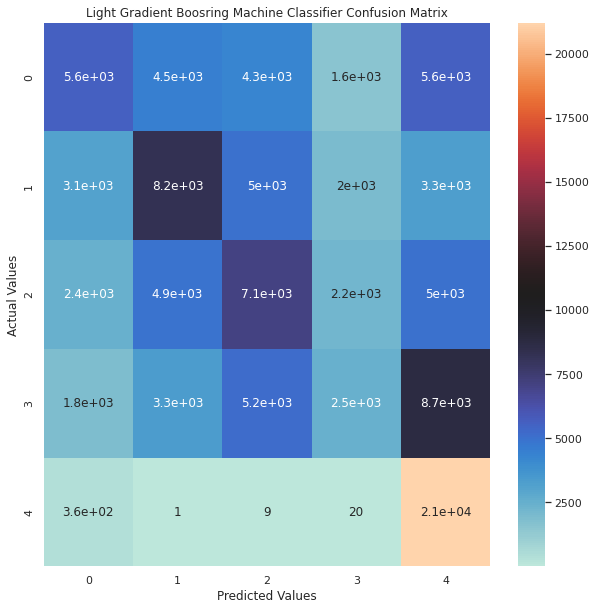

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Light Gradient Boosring Machine Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_lgbm), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

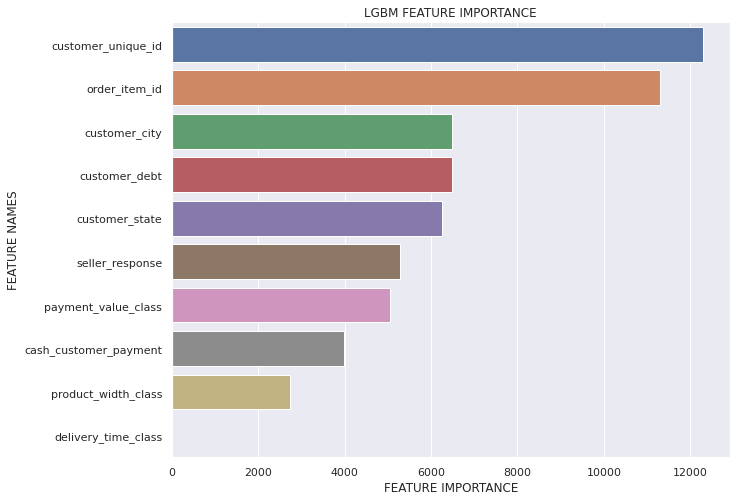

In [ ]:
plot_feature_importance(model_lgbm.feature_importances_, X_filtered.columns, 'LGBM')

####Hyperparamter Tuning

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 200, 400)
    depth =  trial.suggest_int('depth', 8, 14)
    num_leaves = trial.suggest_int('num_leaves', 2, 5)

  

    lgbm = LGBMClassifier(num_leaves = num_leaves, n_estimators = n_estimators, depth = depth,
                          device = "cpu", objective =  'binary', eval_metric =  'logloss', 
                          n_jobs = -1, random_state = 10)

    score = cross_val_score(lgbm, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-03-27 04:14:20,868] A new study created in memory with name: no-name-1bd63812-ede5-4f2a-8037-8dac35ec0ab2
[I 2023-03-27 04:16:12,494] Trial 0 finished with value: 0.42097101296157835 and parameters: {'n_estimators': 387, 'depth': 10, 'num_leaves': 4}. Best is trial 0 with value: 0.42097101296157835.
[I 2023-03-27 04:17:30,781] Trial 1 finished with value: 0.4018898661350865 and parameters: {'n_estimators': 295, 'depth': 8, 'num_leaves': 3}. Best is trial 0 with value: 0.42097101296157835.
[I 2023-03-27 04:18:43,964] Trial 2 finished with value: 0.4111568091917565 and parameters: {'n_estimators': 261, 'depth': 11, 'num_leaves': 4}. Best is trial 0 with value: 0.42097101296157835.
[I 2023-03-27 04:20:15,415] Trial 3 finished with value: 0.4034221938648769 and parameters: {'n_estimators': 352, 'depth': 10, 'num_leaves': 3}. Best is trial 0 with value: 0.42097101296157835.
[I 2023-03-27 04:21:20,643] Trial 4 finished with value: 0.42087523750632905 and parameters: {'n_estimators': 

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.43856086975346625
Best hyperparameters: {'n_estimators': 384, 'depth': 10, 'num_leaves': 5}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
best_params = trial.params
best_params

{'n_estimators': 384, 'depth': 10, 'num_leaves': 5}

In [ ]:
model_lgbm_hp = LGBMClassifier(**best_params, device = "cpu", objective =  'binary',
                               eval_metric =  'logloss', n_jobs = -1, random_state = 10)

model_lgbm_hp.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: depth


LGBMClassifier(depth=10, device='cpu', eval_metric='logloss', n_estimators=384,
               num_leaves=5, objective='binary', random_state=10)

In [ ]:
y_pred_lgbm_hp = model_lgbm_hp.predict(X_test)

In [ ]:
train_acc_lgbm_hp = model_lgbm_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_lgbm_hp*100))

The Accuracy for Training Set is 44.565247133723105


In [ ]:
test_acc_lgbm_hp = accuracy_score(y_test, y_pred_lgbm_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_lgbm_hp*100))

The Accuracy for Test Set is 43.96625957167063


In [ ]:
print(classification_report(y_test, y_pred_lgbm_hp))

              precision    recall  f1-score   support

           1       0.44      0.31      0.36     21600
           2       0.43      0.44      0.43     21600
           3       0.37      0.29      0.32     21600
           4       0.30      0.18      0.22     21601
           5       0.52      0.98      0.68     21600

    accuracy                           0.44    108001
   macro avg       0.41      0.44      0.40    108001
weighted avg       0.41      0.44      0.40    108001



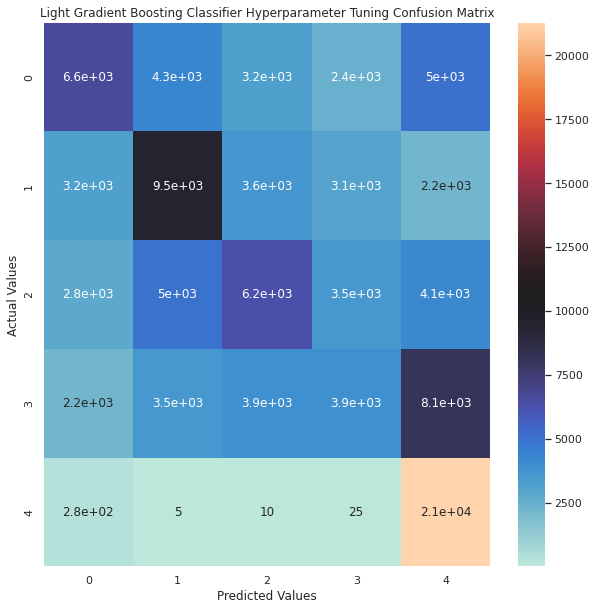

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Light Gradient Boosting Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_lgbm_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

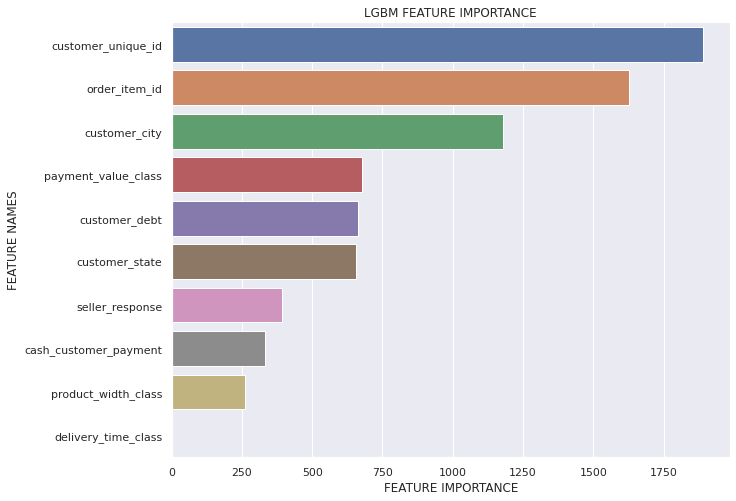

In [ ]:
plot_feature_importance(model_lgbm_hp.feature_importances_, X_filtered.columns, 'LGBM')

### Gradient Boosting Classifier (discarded)

In [ ]:
model_gb = GradientBoostingClassifier( n_estimators = 200, learning_rate = 0.1 , random_state = 10)
model_gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=200, random_state=10)

In [ ]:
y_pred_gb = model_gb.predict(X_test)

In [ ]:
train_acc_gb = model_gb.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_gb*100))

The Accuracy for Training Set is 43.70467998941963


In [ ]:
test_acc_gb = accuracy_score(y_test, y_pred_gb) 
print("The Accuracy for Test Set is {}".format(test_acc_gb*100))

The Accuracy for Test Set is 43.11071193785242


In [ ]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           1       0.43      0.30      0.35     21600
           2       0.42      0.42      0.42     21600
           3       0.35      0.29      0.32     21600
           4       0.30      0.16      0.21     21601
           5       0.51      0.98      0.67     21600

    accuracy                           0.43    108001
   macro avg       0.40      0.43      0.39    108001
weighted avg       0.40      0.43      0.39    108001



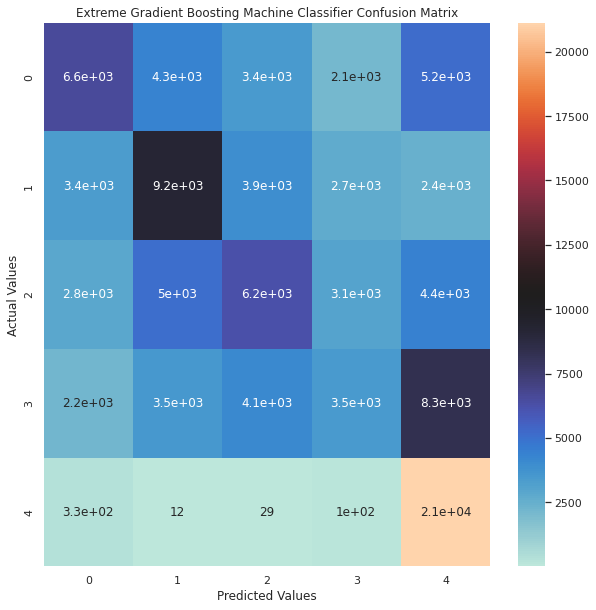

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Extreme Gradient Boosting Machine Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_gb), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

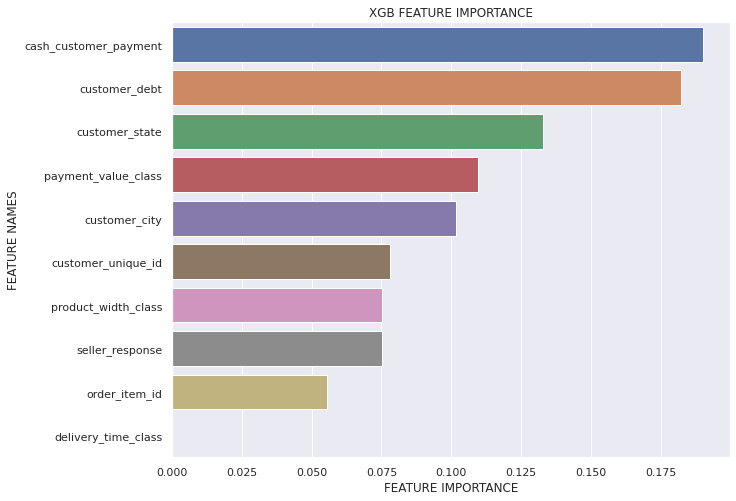

In [ ]:
plot_feature_importance(model_gb.feature_importances_, X_filtered.columns, 'XGB')

####Hyperparamter Tuning

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 200, 400)
    learning_rate =  trial.suggest_int('learning_rate', 0.01, 0.1)

  

    gb = GradientBoostingClassifier( n_estimators = 200, learning_rate = 0.1 , random_state = 10)
    gb.fit(X_train, y_train)

    score = cross_val_score(gb, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-03-27 05:07:47,742] A new study created in memory with name: no-name-e1d6d529-8469-40cd-91a8-a77175aff321
[W 2023-03-27 05:24:43,944] Trial 0 failed with parameters: {'n_estimators': 319, 'learning_rate': 0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-186-29360739abf4>", line 11, in objective
    score = cross_val_score(gb, X_train, y_train, n_jobs = -1, cv = 5)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with

KeyboardInterrupt: ignored

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
best_params = trial.params
best_params

In [ ]:
model_gb_hp = GradientBoostingClassifier(**best_params, n_jobs = -1, random_state = 10)

model_gb_hp.fit(X_train, y_train)

In [ ]:
y_pred_xgb_hp = model_gb_hp.predict(X_test)

In [ ]:
train_acc_gb_hp = model_gb_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_gb_hp*100))

In [ ]:
test_acc_gb_hp = accuracy_score(y_test, y_pred_gb_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_gb_hp*100))

In [ ]:
print(classification_report(y_test, y_pred_gb_hp))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Extreme Gradient Boosting Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_gb_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

In [ ]:
plot_feature_importance(model_gb_hp.feature_importances_, X_filtered.columns, 'LGBM')

###Ensemble All Models (discarded)

In [ ]:
model_vote = VotingClassifier(estimators = [('knn', model_knn_hp), 
                                            ('lgbm', model_lgbm_hp), ('gb', model_gb_hp)],
                               voting = 'hard')

In [ ]:
for model in (model_knn_hp,  model_lgbm_hp, model_gb_hp, model_vote):
  model.fit(X_train, y_train)
  y_pred_vote = model.predict(X_test)
  train_acc_model = model.score(X_train, y_train)
  test_acc_model = accuracy_score(y_test, y_pred_vote) 

In [ ]:
print("The Accuracy for Training Set is {}".format(train_acc_model*100))

In [ ]:
print("The Accuracy for Test Set is {}".format(test_acc_model*100))

In [ ]:
print(classification_report(y_test, y_pred_vote))

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Ensemble Learning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_vote), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

### Accuracy of models implimented (discarded)

In [ ]:
print("The Accuracy of KNighborsClassifier w/ HP for Test Set is {}".format(test_acc_knn_hp*100))
print("The Accuracy of RandomForestClassifier w/ HP  for Test Set is {}".format(test_acc_rfc_hp*100))
print("The Accuracy of LGBMClassifier w/ HP  for Test Set is {}".format(test_acc_lgbm_hp*100))
print("The Accuracy of XGBClassifier w/ HPT for Test Set is {}".format(test_acc_xgb_hp*100))
print("The Accuracy of Ensemble Learning for Test Set is {}".format(test_acc_model*100))

##6. Save Best Model


In [ ]:
filename = 'cust_satis_model.p'

In [ ]:
pickle.dump(model_knn, open(filename, 'wb'))